### Summery
<pre>
Author           : Anjana Tiha
Project Name     : Detection of Pneumonia from Chest X-Ray Images using Convolutional Neural Network, 
                   and Transfer Learning.
Description      : 1. Detected Pneumonia from Chest X-Ray images by retraining pretrained model “InceptionV3” 
                      with 5856 images of X-ray (1.15GB).
                   2. For retraining removed output layers, freezed first few layers and Fine-tuned model for 
                      two new label classes (Pneumonia and Normal).
                   3. Attained testing accuracy 83.44% and loss 0.42.
Method           : 
Tools/Library    : Python, Keras, PyTorch, TensorFlow
Version History  : 1.0.0.0
Current Version  : 1.0.0.0
Last Update      : 11.24.2018
Comments         : Please use Anaconda editor for convenience.
</pre>

#### Code
<pre>
GitHub Link      : <a href=https://github.com/anjanatiha/Detection-of-Pneumonia-from-Chest-X-Ray-Images>Detection of Pneumonia from Chest X-Ray Images(GitHub)</a>
GitLab Link      : <a href=https://gitlab.com/anjanatiha/Detection-of-Pneumonia-from-Chest-X-Ray-Images>Detection of Pneumonia from Chest X-Ray Images(GitLab)</a>
Portfolio        : <a href=https://anjanatiha.wixsite.com/website>Anjana Tiha's Portfolio</a>
</pre>

#### Dataset
<pre>
Dataset Name     : Chest X-Ray Images (Pneumonia)
Dataset Link     : <a href=https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia>Chest X-Ray Images (Pneumonia) Dataset (Kaggle)</a>
                 : <a href=https://data.mendeley.com/datasets/rscbjbr9sj/2>Chest X-Ray Images (Pneumonia) Dataset (Original Dataset)</a>
Original Paper   : <a href=https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5>Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning</a>
                   (Daniel S. Kermany, Michael Goldbaum, Wenjia Cai, M. Anthony Lewis, Huimin Xia, Kang Zhang)
                   https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5
</pre>

#### Library/Tools Version
- Python - v3.6.7
- argparse
- random
- numpy
- shutil
- gc
- re
- Keras - 2.2.4
- Keras-preprocessing - v1.0.5
- TensorFlow - 1.12
- PIL/Pillow - 5.1.0
- Matplotlib - 2.2.2
- scikit-learn - 0.19.1
- mlxtend - 0.14.0

#### Commands / Running Instruction
<pre>
tensorboard --logdir=logs
%config IPCompleter.greedy=True
</pre>

<pre>
<b>Dataset Details</b>
Dataset Name            : Chest X-Ray Images (Pneumonia)
Number of Class         : 2
Number/Size of Images   : Total      : 5856 (1.15 Gigabyte (GB))
                          Training   : 5216 (1.07 Gigabyte (GB))
                          Validation : 320  (42.8 Megabyte (MB))
                          Testing    : 320  (35.4 Megabyte (MB))

<b>Model Parameters</b>
Machine Learning Library: Keras
Base Model              : InceptionV3
Optimizers              : Adam
Loss Function           : categorical_crossentropy

<b>Training Parameters</b>
Batch Size              : 64
Number of Epochs        : 50
Training Time           : 3 Hours

<b>Output (Prediction/ Recognition / Classification Metrics)</b>
<!--<b>Validation</b>-->
<b>Testing</b>
Accuracy                : 83.44%
Loss                    : 0.42
<!--Precision               : -->
Recall                  : 94% (highest)
<!--Specificity             : -->
</pre>

### Import Libraries

In [24]:
from __future__ import print_function

import argparse
import sys
import os

import random

import time
import datetime

from collections import Counter
import numpy as np

import shutil
import inspect

import gc

import re

import keras
from keras import models
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D, GlobalAveragePooling1D
from keras import optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras import backend as K

import tensorflow as tf

from IPython.display import display
from PIL import Image

import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix



## File Functions:
#### Make Delete Directory

In [204]:
# Make or reset directory
def mk_reset_dir(directory, remove=False):
    if remove and os.path.exists(directory):
        try:
            shutil.rmtree(directory)
            os.mkdir(directory)
        except:
            print("Could not remove directory : ", directory)
            return False
    else:
        try:
            os.mkdir(directory)
        except:
            print("Could not create directory: ", directory)
            return False
        
    return True

### Time Functions

In [212]:
def date_time(x):
    if x==1:
        print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
    if x==2:    
        print('Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now()))
    if x==3:  
        print('Date now: %s' % datetime.datetime.now())
    if x==4:  
        print('Date today: %s' % datetime.date.today())  

### Debug Functions

In [213]:
def debug(x):
    print("-"*40, x, "-"*40)  

### String Function

In [214]:
# Remove everything except alphabetical and selected characters from name string
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

### Data Visualization

In [215]:
# count number of files in each subdirectory of a directory
def count_bar(master_directory):
    dir_list = os.listdir(master_directory)
    num_class = len(dir_list)

    dir_name = []
    dir_file_count = []

    for directory in dir_list:
        cur_dir = os.path.join(master_directory, directory)
        count_sample = len(os.listdir(cur_dir))
        dir_name.append(directory)
        dir_file_count.append(count_sample)
    
    return dir_name, dir_file_count
               

# show bar plot for count of labels in a directory
def bar_plot(x, y, title, xlabel, ylabel, figsize=(10,8), title_fontsize = 14, label_fontsize=12, subplot_no=0):
    if subplot_no:
        plt.subplot(subplot_no)
    sns.barplot(x=x, y=y)
    plt.title(title, fontsize=title_fontsize)
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    plt.xticks(range(len(x)), x)
    

# show bar plot for count of labels in a directory
def count_bar_plot(master_directory, title, xlabel, ylabel, figsize=(10,8), title_fontsize = 14, label_fontsize=12, subplot_no=0):
    dir_name, dir_file_count = count_bar(master_directory)
    x=dir_name
    y=dir_file_count
    bar_plot(x, y, title, xlabel, ylabel, figsize=fig_size, title_fontsize=title_fontsize, label_fontsize=label_fontsize, subplot_no=subplot_no)
    
    
def show_train_val_test(training_dir, validation_dir, testing_dir, title, xlabel, ylabel, figsize=(10,8), title_fontsize = 14, label_fontsize=12):
    plt.figure(figsize=fig_size)
    count_bar_plot(training_dir, title +" (Training)", xlabel, ylabel, fig_size, title_fontsize, label_fontsize, subplot_no=131)
    count_bar_plot(validation_dir, title +" (Validation)", xlabel, ylabel, fig_size, title_fontsize, label_fontsize, subplot_no=132)
    count_bar_plot(testing_dir, title +" (Testing)", xlabel, ylabel, fig_size, title_fontsize, label_fontsize, subplot_no=133)
    plt.show()

### Preprocessing Image

In [216]:
# Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches)
def get_transformed_image_batch(directory, target_size, classes, class_mode='categorical', batch_size=1, shuffle=True, rescale=None, shear_range=0.0, zoom_range=0.0, horizontal_flip=False, validation_split=0.0):       
    datagen = ImageDataGenerator(
            rescale=rescale,
            shear_range=shear_range,
            zoom_range=zoom_range,
            horizontal_flip=horizontal_flip,
            validation_split=validation_split)     
    
    image_generator = datagen.flow_from_directory(
            directory,
            target_size=target_size,
            classes = classes,
            class_mode=class_mode,
            batch_size=batch_size)
    return image_generator

### Preprocessing

In [217]:
def get_class_weight(y):
    counter = Counter(y)                          
    max_val = float(max(counter.values()))     
    class_weight = {class_id : max_val/num_images for class_id, num_images in counter.items()}   
    return class_weight

### Tensorflow Graph

In [218]:
def reset_graph(model=None):
    try:
        del model
    except:
        return False
    tf.reset_default_graph()
    K.clear_session()
    gc.collect()
    return True

def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint=None
    reduce_lr = None
    early_stopping = None
    tensorboard = None

### Model Initialization
#### Load and Configure Model Function InceptionV3 for Fine-Tuning with New Class Labels
<p>1. Imports Pretrained model InceptionV3 <br>
   2. Disabled training on first few layers <br>
   3. Enabled training on top and output layers<br>
   4. Adjust output Dense Layer to number of Image Classes <br>
</p>

In [219]:
# Load and Configure Model Function InceptionV3 for Fine-Tuning with New Class Labels
def get_inception_model(train_generator, validation_generator, epochs, verbose, sgd, loss, metrics, tensorboard, callbacks, num_class, include_top=False, non_trainable_index=249, print_layers = False):    
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=include_top)

    # add a global spatial average pooling layer
    # Setting model layers specially output layer with class number
    x = base_model.output
    
    x = GlobalAveragePooling2D()(x)
    
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    
    # and a logistic layer -- let's say we have 2 classes

    # softmax for multi-class
    predictions = Dense(num_class, activation='softmax')(x) 
    
    # sigmoid for 2 class or binary class
    # predictions = Dense(num_class, activation='sigmoid')(x) 

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
     
    # compile model with loss, optimizer and metrics 
    model.compile(sgd, loss=loss, metrics=metrics)
    
    if callbacks:
        tensorboard.set_model(model) 
    
    # train the model on the new data for a few epochs
    model.fit_generator(train_generator,
                        steps_per_epoch = len(train_generator),
                        epochs=epochs,
                        # verbose=verbose, 
                        callbacks=callbacks,
                        validation_data=validation_generator,
                        validation_steps=len(validation_generator),
                        class_weight = class_weight)

    # at this point, the top layers are well trained and we can start fine-tuning
    # convolutional layers from inception V3. We will freeze the bottom N layers
    # and train the remaining top layers.

    # let's visualize layer names and layer indices to see how many layers
    # we should freeze:
    if print_layers:
        for i, layer in enumerate(base_model.layers):
            print(i, layer.name)

    # Freeze or set first few layers as untrainable
    # Unfreeze or set rest of the layers as trainable
    for layer in model.layers[:non_trainable_index]:
        layer.trainable = False
    for layer in model.layers[non_trainable_index:]:
        layer.trainable = True
        
    model.summary()
        
    return model


### Performance Metrics

In [220]:
def reverse_pos_neg(CM, print_bool):
    tp=CM[0][0]
    fp=CM[0][1]
    fn=CM[1][0]
    tn=CM[1][1]
    if print_bool:
        print(tp, fp, tn, fn, tn)
    return [tp, fp, tn, fn, tn]


def report(CM, reverse):
    if not reverse:
        tn, fp, fn, tp = CM.ravel()

    else:
        tp=CM[0][0]
        fp=CM[0][1]
        fn=CM[1][0]
        tn=CM[1][1]
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    print("Recall of the model is {:.2f}".format(recall))
    print("Precision of the model is {:.2f}".format(precision))
    
    return precision, recall

### Performance Visualization

In [268]:
# Plot training & validation accuracy values
    
def plot_history(history, plot_val, title, xlabel, ylabel, legend=[['Train', 'Val'], ['Train', 'Val']], fig_size=(10,8), title_fontsize = 14, label_fontsize=12):
    plt.figure(figsize=fig_size)
    
    plt.subplot(121)
    plt.plot(history.history[plot_val[0][0]])
    plt.plot(history.history[plot_val[0][1]])
    plt.title(title[0], fontsize=title_fontsize)
    plt.ylabel(ylabel[0], fontsize=label_fontsize)
    plt.xlabel(xlabel[0], fontsize=label_fontsize)
    plt.legend(legend[0], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history[plot_val[1][0]])
    plt.plot(history.history[plot_val[1][1]])
    plt.title(title[1], fontsize=title_fontsize)
    plt.ylabel(ylabel[1], fontsize=label_fontsize)
    plt.xlabel(xlabel[1], fontsize=label_fontsize)
    plt.legend(legend[1], loc='upper left')
    plt.show()

### Testing

In [291]:
def predict_report(model, test_generator, classes, print_report=False):
    y_preds = model.predict_generator(test_generator, steps=len(test_generator))
    y_classes = y_preds.argmax(axis=-1)

    CM = confusion_matrix(test_generator.classes, y_classes)
    CM_report = classification_report(test_generator.classes, y_classes, target_names=classes)
    
    if print_report: 
        print(CM_report)
    return y_preds, y_classes, CM, CM_report

def model_evaluate(model, test_generator, print_report=False):
    result = model.evaluate_generator(generator=test_generator, steps=len(test_generator))
    
    accuracy = result[1]*100
    loss = result[0]
    
    if print_report:
        print("%s%.2f%s"% ("Accuracy: ", accuracy, "%"))
        print("%s%.2f"% ("Loss: ", loss))
    
    return accuracy, loss

def test_all_models(model_dir, details, report_type, classes):
    results = {}
    
    model_files = os.listdir(model_dir)
    
    i=0
    model = None
    for model_file in model_files:
        
        model_path = model_dir+"\\"+model_file
        
        if not path.isdir(model_path):
            reset_graph(model)

            model = keras.models.load_model(model_path)

            if report_type=="Complete":
                y_preds, y_classes, CM, CM_report = predict_report(model, test_generator, classes)
                results[model_file] = [CM, CM_report]

            else:
                accuracy, loss =  model_evaluate(model, test_generator, print_report=False)

                results[model_file] = [accuracy, loss]


            if details:
                print("%s%s"%("Model No: ", i+1))
                print("%s%s"%("Model File: ", model_file))
                print("*"*80)
                if report_type=="Complete":
                    print(CM_report)
                else:
                    print("%s%.2f%s"% ("Accuracy: ", accuracy, "%"))
                    print("%s%.2f"% ("Loss: ", loss))

                print("-"*80)
                print("-"*80)

            elif not details and i%10==0:
                print("%s%s"%("Model No: ", i+1))
                print("%s%s"%("Model File: ", model_file))
                print("*"*80)
                if report_type=="Complete":
                    print(CM_report)
                else:
                    print("%s%.2f%s"% ("Accuracy: ", accuracy, "%"))
                    print("%s%.2f"% ("Loss: ", loss))
                print("-"*80)
                print("-"*80)

            i+=1
    print("Test complete")
    
    return results

### Testing Visualizations

In [316]:
def line_plot_over_epochs(array, title, xlabel="Epoch", ylabel="Value", title_fontsize=14, label_fontsize=12, subplot_no=0):
    x_axis_arr = np.arange(len(array))
    if subplot_no:
        plt.subplot(subplot_no)
    plt.title(title, fontsize=title_fontsize)
    plt.plot(x_axis_arr, array)
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    
def line_plot_over_epochs_loss_acc(array, title, fig_size=(10, 8), xlabel=["Epoch", "Epoch"], ylabel=["Value","Value"], title_fontsize=14, label_fontsize=12):
    plt.figure(figsize=fig_size)
    line_plot_over_epochs(array[0], title[0], xlabel=xlabel[0], ylabel=ylabel[0], title_fontsize=title_fontsize, label_fontsize=label_fontsize, subplot_no=121)
    line_plot_over_epochs(array[1], title[1], xlabel=xlabel[1], ylabel=ylabel[1], title_fontsize=title_fontsize, label_fontsize=label_fontsize, subplot_no=122)
    plt.show()

## Data Import and Visualization

In [317]:
reset_graph(model)

True

In [318]:
# Configure input/ output directory
# Configure training, validation, testing directory

input_directory = r"data/input/"
output_directory = r"data/output/"

training_dir = input_directory+ r"train"
testing_dir = input_directory+ r"test"
validation_dir = input_directory+ r"val"

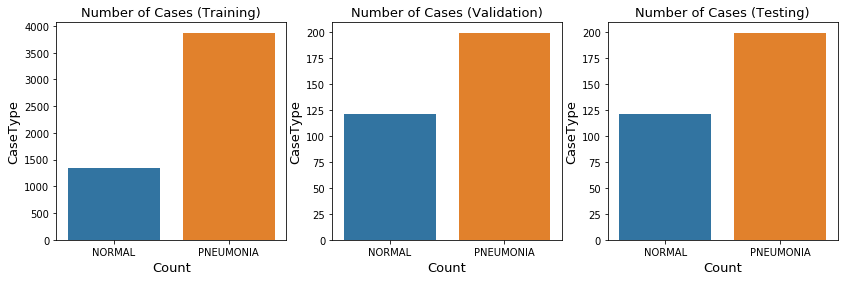

In [319]:
xlabel="Count"
ylabel="CaseType"
fig_size = (14,4)
# fig_size = (4,2)
# title_fontsize=14
title_fontsize=13
# label_fontsize=12
label_fontsize=13
title="Number of Cases"


show_train_val_test(training_dir, validation_dir, testing_dir, title, xlabel, ylabel, figsize=fig_size, title_fontsize = title_fontsize, label_fontsize=label_fontsize)


### Image Preprocessing
#### Setting up Parameters for Image Transformation of Training, Validation, Testing and  Dataset 

In [320]:
# Get number of label/ class / category
num_class = len(os.listdir(training_dir))
print(num_class)


#Image Augmentation/ Preprocessing before training
norm = 255.0
rescale=1./norm
shear_range=0.2
zoom_range=0.2
horizontal_flip=True


# flow from directory function
# Target Image dimention
target_size=(224, 224)

# Batch size
# train
# batch_size=32
# batch_size=64
batch_size=128

# validation
validation_batch_size=1
# test
test_batch_size=1

# shuffle
# test
test_shuffle=False

# validation split for train
validation_split = 0.0

# class mode
# class_mode='binary'
class_mode='categorical'
# class_mode='sparse'


classes = ['Normal', 'PNEUMONIA']

2


### Transformation of Image in Image Dataset for Training, Validation, Testing

In [321]:
train_generator = get_transformed_image_batch(training_dir, target_size, classes, class_mode=class_mode, batch_size=batch_size, rescale=rescale, shear_range=shear_range, zoom_range=zoom_range, horizontal_flip=horizontal_flip)       

validation_generator = get_transformed_image_batch(validation_dir, target_size, classes, class_mode=class_mode, batch_size=validation_batch_size, rescale=rescale)       

test_generator = get_transformed_image_batch(validation_dir, target_size, classes, class_mode=class_mode, batch_size=test_batch_size, shuffle = test_shuffle, rescale=rescale) 

Found 5216 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [322]:
y=train_generator.classes
class_weight=get_class_weight(y)
class_weight

{0: 2.889634601043997, 1: 1.0}

## Training Parameter Settings


In [323]:
# setting model and log output directory
model_dir =  output_directory + r"models/"
log_dir = output_directory + r"logs"

# make or reset directory
# mk_reset_dir(model_dir, False)
# mk_reset_dir(log_dir, False)

model_file = model_dir+"base-"+"{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"


##### Base Model - InceptionV3 (pretrained) initial training settings

# inception base top layer discarded
include_top = False

# number of layers freezed
non_trainable_index = 249

init_sgd = optimizers.Adam()

print_layers=False

# initial epochs on only output layers
# init_epochs=1
# initial_epochs=3
init_epochs=20

# verbose
init_verbose = 0

# callbacks
init_callbacks = None

# model report
print_report = True


### Full model training parameter configuration for Loss, Optimizer and Performance Metrics

# optimizer
# adam lr=0.01/0.001/0.0001/0.00001/0.000001, decay = decay=1e-5/ 1e-6
sgd = optimizers.Adam()


# loss function
# loss='binary_crossentropy'
loss='categorical_crossentropy'


# performance metrics ('accuracy', 'binary_accuracy', precision, recall)
metrics=['accuracy']


### Main model training parameter configuration

# epochs = 20/30/50
epochs = 30

# steps
steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)

# verbose 0=nothing 1=each line
verbose = 0


#### Configuration for Callbacks - CheckPoint, ReduceLROnPlateau, Early Stopping, TensorBoard

# checkpoint
ck_monitor='val_acc'
ck_verbose=0
ck_save_best_only=False
ck_save_weights_only=False
ck_mode='auto'
ck_period=1

# ReduceLROnPlateau
red_lr_monitor='val_loss'
red_lr_factor=0.1 # default
# red_lr_patience=5
red_lr_patience=2
red_lr_verbose=1
red_lr_mode='auto'
red_lr_min_delta=0.0001
red_lr_cooldown=0
# red_lr_min_lr=0.0001 # default
red_lr_min_lr=0.000001


# early_stopping
es_monitor = 'val_loss'
es_min_delta=0
# es_patience=0
es_patience=5
es_verbose=0
es_mode='auto'
es_baseline=None

# tensorboard
tb_histogram_freq=0
tb_batch_size=batch_size
tb_write_graph=True
tb_write_grads=False
tb_write_images=False
tb_embeddings_freq=0
tb_embeddings_layer_names=None
tb_embeddings_metadata=None
tb_embeddings_data=None

### Setup Callbacks - CheckPoint, ReduceLROnPlateau, Early Stopping, TensorBoard

In [324]:
checkpoint = ModelCheckpoint(model_file, monitor=ck_monitor, verbose=ck_verbose, save_best_only=ck_save_best_only, save_weights_only=ck_save_weights_only, mode=ck_mode, period=ck_period)

reduce_lr = ReduceLROnPlateau(monitor=red_lr_monitor, factor=red_lr_factor, patience=red_lr_patience, verbose=red_lr_verbose, mode=red_lr_mode, min_delta=red_lr_min_delta, cooldown=red_lr_cooldown, min_lr=red_lr_min_lr)

early_stopping = EarlyStopping(monitor=es_monitor, min_delta=es_min_delta, patience=es_patience, verbose=es_verbose, mode=es_mode, baseline=es_baseline)

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=tb_histogram_freq, batch_size=tb_batch_size, write_graph=tb_write_graph, write_grads=tb_write_grads, write_images=tb_write_images, embeddings_freq=tb_embeddings_freq, embeddings_layer_names=tb_embeddings_layer_names, embeddings_metadata=tb_embeddings_metadata, embeddings_data=tb_embeddings_data)

In [325]:
# callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
callbacks = [checkpoint, reduce_lr, tensorboard]
# callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]

# Training Base Model

In [ ]:
# # get inception model
model = get_inception_model(train_generator, validation_generator, init_epochs, init_verbose, init_sgd, loss, metrics, tensorboard, init_callbacks, num_class, include_top, non_trainable_index, print_layers)
only_output_layer_trained_model = model

Epoch 1/20
41/41 [==============================] - 151s 4s/step - loss: 0.8338 - acc: 0.7660 - val_loss: 0.5704 - val_acc: 0.7438
Epoch 2/20
41/41 [==============================] - 149s 4s/step - loss: 0.4169 - acc: 0.8900 - val_loss: 0.5606 - val_acc: 0.7531
Epoch 3/20
41/41 [==============================] - 137s 3s/step - loss: 0.3625 - acc: 0.9034 - val_loss: 0.6366 - val_acc: 0.7375
Epoch 4/20
41/41 [==============================] - 128s 3s/step - loss: 0.3471 - acc: 0.9052 - val_loss: 0.7244 - val_acc: 0.7250
Epoch 5/20
19/41 [============>.................] - ETA: 58s - loss: 0.2939 - acc: 0.9153 

In [ ]:
y_preds, y_classes, CM, CM_report = predict_report(model, test_generator, classes, print_report)
accuracy, loss =  model_evaluate(model, test_generator, print_report)

## Training New Model most layers and all parameters

In [19]:
# train inception model
# fine-tuning the top layers
# compile model with loss, optimizer and metrics 
model.compile(sgd, loss=loss, metrics=metrics)
tensorboard.set_model(model) 

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    class_weight=class_weight)
 

Epoch 1/30
41/41 [==============================] - 128s 3s/step - loss: 0.3083 - acc: 0.9197 - val_loss: 1.7977 - val_acc: 0.6438
Epoch 2/30
41/41 [==============================] - 133s 3s/step - loss: 0.2278 - acc: 0.9381 - val_loss: 2.0438 - val_acc: 0.6250
Epoch 3/30
41/41 [==============================] - 143s 3s/step - loss: 0.1908 - acc: 0.9487 - val_loss: 1.7045 - val_acc: 0.6500
Epoch 4/30
41/41 [==============================] - 133s 3s/step - loss: 0.1826 - acc: 0.9533 - val_loss: 1.6648 - val_acc: 0.6406
Epoch 5/30
41/41 [==============================] - 135s 3s/step - loss: 0.1572 - acc: 0.9578 - val_loss: 1.6382 - val_acc: 0.6344
Epoch 6/30
41/41 [==============================] - 134s 3s/step - loss: 0.1569 - acc: 0.9592 - val_loss: 1.0074 - val_acc: 0.6656
Epoch 7/30
41/41 [==============================] - 135s 3s/step - loss: 0.1524 - acc: 0.9602 - val_loss: 1.3129 - val_acc: 0.6500
Epoch 8/30
41/41 [==============================] - 138s 3s/step - loss: 0.1366 - a

### Model Performance Visualization over the Epochs

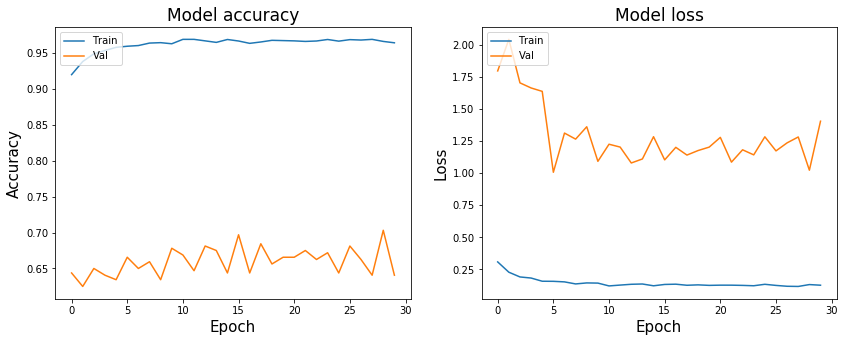

In [290]:
title = ['Model accuracy', 'Model loss']
xlabel = ['Epoch', 'Epoch']
ylabel = ['Accuracy', 'Loss']
legend = ['Train', 'Val']
plot_val=[['acc', 'val_acc'], ['loss', 'val_loss']]
fig_size=(14, 5)
title_fontsize = 17
label_fontsize=15

plot_history(history, plot_val, title, xlabel, ylabel, fig_size=fig_size, title_fontsize=title_fontsize, label_fontsize=label_fontsize)

In [34]:
details = True
# report_type = "Acc_Loss"
report_type = "Complete"

results=test_all_models(model_dir, details, report_type, classes)

Model No: 1
Model File: 01-val_acc-0.63-val_loss-1.34.hdf5
********************************************************************************
             precision    recall  f1-score   support

     Normal       0.50      0.01      0.02       121
  PNEUMONIA       0.62      0.99      0.77       199

avg / total       0.58      0.62      0.48       320

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


C:\Users\Andromeda\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Model No: 2
Model File: 01-val_acc-0.64-val_loss-1.80.hdf5
********************************************************************************
             precision    recall  f1-score   support

     Normal       0.00      0.00      0.00       121
  PNEUMONIA       0.62      1.00      0.77       199

avg / total       0.39      0.62      0.48       320

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model No: 3
Model File: 02-val_acc-0.58-val_loss-1.86.hdf5
********************************************************************************
             precision    recall  f1-score   support

     Normal       1.00      0.01      0.02       121
  PNEUMONIA       0.62      1.00      0.77       199

avg / total       0.77      0.62      0.48       320

--------------------------------------------------------------------------------
-----------------------------------------------

C:\Users\Andromeda\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Model No: 4
Model File: 02-val_acc-0.62-val_loss-2.04.hdf5
********************************************************************************
             precision    recall  f1-score   support

     Normal       0.00      0.00      0.00       121
  PNEUMONIA       0.62      1.00      0.77       199

avg / total       0.39      0.62      0.48       320

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model No: 5
Model File: 03-val_acc-0.65-val_loss-1.70.hdf5
********************************************************************************
             precision    recall  f1-score   support

     Normal       1.00      0.01      0.02       121
  PNEUMONIA       0.62      1.00      0.77       199

avg / total       0.77      0.62      0.48       320

--------------------------------------------------------------------------------
-----------------------------------------------

Model No: 20
Model File: 18-val_acc-0.68-val_loss-1.14.hdf5
********************************************************************************
             precision    recall  f1-score   support

     Normal       0.08      0.01      0.02       121
  PNEUMONIA       0.61      0.94      0.74       199

avg / total       0.41      0.59      0.47       320

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model No: 21
Model File: 19-val_acc-0.66-val_loss-1.18.hdf5
********************************************************************************
             precision    recall  f1-score   support

     Normal       0.08      0.01      0.02       121
  PNEUMONIA       0.61      0.94      0.74       199

avg / total       0.41      0.59      0.47       320

--------------------------------------------------------------------------------
---------------------------------------------

OSError: Unable to open file (unable to open file: name = 'data/output/models/\old', errno = 13, error message = 'Permission denied', flags = 0, o_flags = 0)

## Retraining Best Model
### Configuration for Retraining

In [23]:
# reset_callbacks(checkpoint, reduce_lr, early_stopping, tensorboard)
# reset_graph(model)

In [303]:
# setting model and log output directory
model_dir =  output_directory + r"models/"
log_dir = output_directory + r"logs"

# make or reset directory
# mk_reset_dir(model_dir, False)
# mk_reset_dir(log_dir, False)

model_file = model_dir+"base-"+"{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"


##### Base Model - InceptionV3 (pretrained) initial training settings

# inception base top layer discarded
include_top = False

# number of layers freezed
non_trainable_index = 249

print_layers=False

# initial epochs on only output layers
# init_epochs=1
# initial_epochs=3
init_epochs=20

# verbose
init_verbose = 0

# callbacks
init_callbacks = None

# model report
print_report = True


### Full model training parameter configuration for Loss, Optimizer and Performance Metrics

# optimizer
# adam lr=0.01/0.001/0.0001/0.00001/0.000001, decay = decay=1e-5/ 1e-6
sgd = optimizers.Adam()


# loss function
# loss='binary_crossentropy'
loss='categorical_crossentropy'


# performance metrics ('accuracy', 'binary_accuracy', precision, recall)
metrics=['accuracy']


### Main model training parameter configuration

# epochs = 20/30/50
epochs = 30

# steps
steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)

# verbose 0=nothing 1=each line
verbose = 0


#### Configuration for Callbacks - CheckPoint, ReduceLROnPlateau, Early Stopping, TensorBoard

# checkpoint
ck_monitor='val_acc'
ck_verbose=0
ck_save_best_only=False
ck_save_weights_only=False
ck_mode='auto'
ck_period=1

# ReduceLROnPlateau
red_lr_monitor='val_loss'
red_lr_factor=0.1 # default
# red_lr_patience=5
red_lr_patience=2
red_lr_verbose=1
red_lr_mode='auto'
red_lr_min_delta=0.0001
red_lr_cooldown=0
# red_lr_min_lr=0.0001 # default
red_lr_min_lr=0.000001


# early_stopping
es_monitor = 'val_loss'
es_min_delta=0
# es_patience=0
es_patience=5
es_verbose=0
es_mode='auto'
es_baseline=None

# tensorboard
tb_histogram_freq=0
tb_batch_size=batch_size
tb_write_graph=True
tb_write_grads=False
tb_write_images=False
tb_embeddings_freq=0
tb_embeddings_layer_names=None
tb_embeddings_metadata=None
tb_embeddings_data=None

################################################ Retrain #########################################################
initial_epoch = epochs+1
##################################################################################################################

### Retraining (Best Model)
#### Setup Callbacks - CheckPoint, ReduceLROnPlateau, Early Stopping, TensorBoard

In [ ]:
checkpoint = ModelCheckpoint(model_file, monitor=ck_monitor, verbose=ck_verbose, save_best_only=ck_save_best_only, save_weights_only=ck_save_weights_only, mode=ck_mode, period=ck_period)

reduce_lr = ReduceLROnPlateau(monitor=red_lr_monitor, factor=red_lr_factor, patience=red_lr_patience, verbose=red_lr_verbose, mode=red_lr_mode, min_delta=red_lr_min_delta, cooldown=red_lr_cooldown, min_lr=red_lr_min_lr)

early_stopping = EarlyStopping(monitor=es_monitor, min_delta=es_min_delta, patience=es_patience, verbose=es_verbose, mode=es_mode, baseline=es_baseline)

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=tb_histogram_freq, batch_size=tb_batch_size, write_graph=tb_write_graph, write_grads=tb_write_grads, write_images=tb_write_images, embeddings_freq=tb_embeddings_freq, embeddings_layer_names=tb_embeddings_layer_names, embeddings_metadata=tb_embeddings_metadata, embeddings_data=tb_embeddings_data)

In [ ]:
callbacks = [checkpoint, reduce_lr, tensorboard]
# callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]

## Retraining (Best Model)
#### Selecting best model file based on validation accuracy mentioned in file names

In [ ]:
# selecting best model file / checkpoint for retraining
# model_path = model_dir+r"12-val_acc-0.70-val_loss-1.09.hdf5"
# model_path = model_dir+r"20-val_acc-0.66-val_loss-1.97.hdf5"

model_path = model_dir+r"20-val_acc-0.71-val_loss-1.26.hdf5"

model = keras.models.load_model(model_path)

# train inception model
# fine-tuning the top layers
# compile model with loss, optimizer and metrics 
model.compile(sgd, loss=loss, metrics=metrics)
tensorboard.set_model(model) 

# retrain by loading last good model
history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    # verbose=1,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    class_weight=class_weight,
    initial_epoch=initial_epoch)
 

#### Plotting all model performance over all epochs and models for accuracy and loss

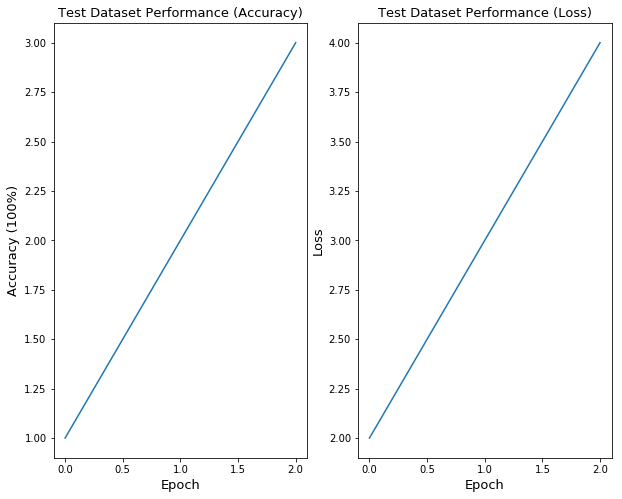

In [315]:


array=[[1,2,3],[2,3,4]]
fig_size = (10, 8)
title=["Test Dataset Performance (Accuracy)", "Test Dataset Performance (Loss)"]
xlabel=["Epoch", "Epoch"]
ylabel=["Accuracy (100%)", "Loss"]
line_plot_over_epochs_loss_acc(array, title, fig_size=fig_size, xlabel=xlabel, ylabel=ylabel, title_fontsize=title_fontsize, label_fontsize=label_fontsize)

##### Selecting Best Model for full evaluation (for accuracy/f1 score or recall)

In [ ]:
# best accuracy/ F-1 score
# model_path = "data/output/models/"+"17-val_acc-0.82-val_loss-0.42.hdf5"

# Lowest validation Loss
# model_path = "data/output/models/"+"12-val_acc-0.70-val_loss-1.09.hdf5"

# Best Recall
model_path = "data/output/models/"+"20-val_acc-0.66-val_loss-1.97.hdf5"

In [ ]:
from sklearn.metrics import roc_auc_score

def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id



test_filenames = test_generator.filenames
df_preds = pd.DataFrame(predictions, columns=classes)
df_preds['file_names'] = test_filenames
df_preds['id'] = df_preds['file_names'].apply(extract_id)
df_preds.head()

# Get the true labels
y_true = test_generator.classes

# Get the predicted labels as probabilities
y_pred = df_preds['Cancer']

fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

roc_auc_score(y_true, y_pred)


In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

submission.to_csv('patch_preds.csv', columns=['label']) 
submission.head()

##### Showing Confusion Matrix of Model Performance for Test Dataset

In [ ]:
def show_confusion_matrix(test_generator, y_classes, classes, figsize, stick_fontsize):
    CM = confusion_matrix(test_generator.classes, y_classes)
    fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=figsize, hide_ticks=True,cmap=plt.cm.Blues)
    plt.xticks(range(len(classes)), classes, fontsize=stick_fontsize)
    plt.yticks(range(len(classes)), classes, fontsize=stick_fontsize)
    plt.show()
    return CM

CM = confusion_matrix(test_generator.classes, y_classes)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), classes, fontsize=16)
plt.yticks(range(2), classes, fontsize=16)
plt.show()

##### Showing precision, recall, f1-score, support for Model Performance over Test Dataset

In [ ]:
classification_report_print = classification_report(test_generator.classes, y_classes, target_names=target_names)
print(classification_report_print)

##### Showing calcualted precision, recall for Model over Test Dataset

In [ ]:
# Calculate Precision and Recall
tn, fp, fn, tp = CM.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))


##### Retriving actual labels 

In [ ]:
label_map = (test_generator.class_indices)
label_map_rev = {v: name_correct(k) for k,v in label_map.items()}
num_batch_t = len(test_generator)
print(label_map)
print(label_map_rev)

##### Showing accuracy for Model over Single Batch of Test Dataset

In [ ]:
num = random.randint(0, num_batch_t-1)
y_img_batch, y_class_batch = test_generator[num] 
y_pred = np.argmax(model.predict(y_img_batch),-1)
y_true = np.argmax(y_class_batch,-1)
print("Selected Batch No: %d\nBatch Size: %d"%(num, len(y_pred)))
print("Accuracy : ", sum(y_pred==y_true)/batch_size*100, "%")

y_true_labels = [label_map_rev[c] for c in y_true]
y_pred_labels = [label_map_rev[c] for c in y_pred]
batch_size_t = len(y_true_labels)

### Visualization 
Visualization of performance of a random test dataset batch and few random images from a batch

#### Visualization 1 (Random Batch)
Visualization of performance of a random test dataset batch

Setting parameters for visualization 1

In [ ]:
figure_directory = "data/output/figures"
image_file_name = figure_directory+"/result"

dpi=100

update_image = True


cols = 8
rows= batch_size_t/cols
if batch_size_t%cols==0:
    rows = int(batch_size_t/cols)
else:
    rows = int(batch_size_t/cols)+1
    
figsize_col = cols*2.5
figsize_row = rows*2.5

hspace = 0.5
wspace = 0.3

facecolor='w'
edgecolor='k'

titlesize = 'small'

true_prediction_label_color='black'
false_prediction_label_color='red'

true_label_title_prefix = "org : "
pred_label_title_prefix = "pred: "

if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)

#### Visualization 1 (Random Batch)
Visualization of performance of a random test dataset batch

In [ ]:
# figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(figsize_col, figsize_row),
                        dpi=dpi, facecolor=facecolor, edgecolor=edgecolor,
                        subplot_kw={'xticks': [], 'yticks': []})


plt.rcParams.update({'axes.titlesize': titlesize})
plt.subplots_adjust(hspace=hspace, wspace=wspace)

for i in range(0, batch_size_t): # how many imgs will show from the mxn grid
    plt.subplot(rows, cols, i+1)
    
    plt.imshow(y_img_batch[i])
    
    plt.xticks([])
    plt.yticks([])
    
    if y_true_labels[i]==y_pred_labels[i]:
        plt.title(true_label_title_prefix + y_true_labels[i] + "\n" + pred_label_title_prefix + y_pred_labels[i])
    else:
        plt.title(true_label_title_prefix + y_true_labels[i] + "\n" + pred_label_title_prefix + y_pred_labels[i], color=false_prediction_label_color)
        
    if update_image and os.path.exists(image_file_name):
        os.remove(image_file_name)
    
    fig.savefig(image_file_name, dpi=dpi)

plt.tight_layout()
plt.show()

#### Visualization 2 (Random) 
Visualization of performance of a few random images from a random batch

Setting parameters for visualization 2

In [ ]:
figure_directory = "data/output/figures"
image_file_name = figure_directory+"/sample"

dpi=100

update_image = True

cols = 4
rows= 2

count = rows*cols
    
figsize_col = cols*2.5
figsize_row = rows*2.5

hspace = 0.5
wspace = 0.3

# titlesize = 'small'

true_prediction_label_color='black'
false_prediction_label_color='red'

true_label_title_prefix = "org:  "
pred_label_title_prefix = "pred: "

#### Visualization 2 (Random) 
Visualization of performance of a few random images from a random batch

In [ ]:
# figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(figsize_col, figsize_row),
                        dpi=dpi, facecolor=facecolor, edgecolor=edgecolor,
                        subplot_kw={'xticks': [], 'yticks': []})

plt.rcParams.update({'axes.titlesize': titlesize})
plt.subplots_adjust(hspace=hspace, wspace=wspace)


batch_size_tmp = batch_size_t

m = {}

for i in range(0, count): 
    num = random.randint(0, batch_size_tmp-1)
    while num in m:
        num = random.randint(0, batch_size_tmp-1)
    
    m[num]=1
    
    plt.subplot(rows, cols, i+1)
    
    plt.imshow(y_img_batch[num])
    
    plt.xticks([])
    plt.yticks([])
    
    if y_true_labels[num]==y_pred_labels[num]:
        plt.title(true_label_title_prefix + y_true_labels[num] + "\n" + pred_label_title_prefix + y_pred_labels[num])
    else:
        plt.title(true_label_title_prefix + y_true_labels[num] + "\n" + pred_label_title_prefix + y_pred_labels[num], color=false_prediction_label_color)
    
   
    if update_image and os.path.exists(image_file_name):
        os.remove(image_file_name)   
    
    fig.savefig(image_file_name, dpi=dpi)


plt.tight_layout()
plt.show()